In [49]:
from numpy import *
from pathlib import Path

In [4]:
#7.3 基于单层决策树构建弱分类器

In [18]:
def loadSimpData():
    datMat = matrix([[ 1. ,  2.1],
        [ 2. ,  1.1],
        [ 1.3,  1. ],
        [ 1. ,  1. ],
        [ 2. ,  1. ]])
    classLabels = [1.0, 1.0, -1.0, -1.0, 1.0]
    return datMat,classLabels

In [19]:
dataMat,classLabels = loadSimpData()

In [7]:
def stumpClassify(dataMatrix,dimen,threshVal,threshIneq):
    retArray = ones((shape(dataMatrix)[0],1))
    if threshIneq == 'lt':
        retArray[dataMatrix[:,dimen] <= threshVal] = -1.0
    else:
        retArray[dataMatrix[:,dimen] > threshVal] = -1.0
    return retArray

In [33]:
def buildStump(dataArr,classLabels,D):
    dataMatrix = mat(dataArr)
    labelMat = mat(classLabels).T
    
    m,n = shape(dataMatrix)
    
    numSteps = 10.0
    bestStump = {}
    bestClasEst = mat(zeros((m,1)))
    
    minError = inf
    
    for i in range(n):
        rangeMin = dataMatrix[:,i].min()
        rangeMax = dataMatrix[:,i].max()
        
        stepSize = (rangeMax - rangeMin)/numSteps
        
        for j in range(-1,int(numSteps) + 1):
            for inequal in ['lt','gt']:
                threshVal = rangeMin + float(j) * stepSize
                predictedVals = stumpClassify(dataMatrix,i,threshVal,inequal)
                errArr = mat(ones((m,1)))
                
                errArr[predictedVals == labelMat] = 0
                weightedError = D.T * errArr
                
                if weightedError < minError:
                    minError = weightedError
                    bestClasEst = predictedVals.copy()
                    bestStump['dim'] = i
                    bestStump['thresh'] = threshVal
                    bestStump['ineq'] = inequal
    return bestStump,minError,bestClasEst
    

In [34]:
D = mat(ones((5,1))/5)

In [35]:
buildStump(dataMat,classLabels,D)

({'dim': 0, 'thresh': 1.3, 'ineq': 'lt'},
 matrix([[0.2]]),
 array([[-1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.]]))

In [36]:
#7.4 完整的多个弱分类器版的AdaBoost算法

In [37]:
def adaBoostTrainDS(dataArr,classLabels,numIt = 40):
    weakClassArr = []
    m = shape(dataArr)[0]
    D = mat(ones((m,1))/m)
    aggClassEst = mat(zeros((m,1)))
    for i in range(numIt):
        bestStump,error,classEst = buildStump(dataArr,classLabels,D)
        
        alpha = float(0.5*log((1.0-error)/max(error,1e-16)))
        bestStump['alpha'] = alpha
        weakClassArr.append(bestStump)
        
        expon = multiply(-1 * alpha * mat(classLabels).T, classEst)
        D = multiply(D,exp(expon))
        
        D = D/D.sum()
        
        aggClassEst += alpha * classEst
        
        aggErrors = multiply(sign(aggClassEst) != mat(classLabels).T, ones((m,1)))
        errorRate = aggErrors.sum()/m
        
        print('total error: ',errorRate,'\n')
        if errorRate == 0.0:
            break
    return weakClassArr

In [43]:
classifierArr = adaBoostTrainDS(dataMat,classLabels,9)

total error:  0.2 

total error:  0.2 

total error:  0.0 



In [46]:
#测试算法：累加多个分类器在同一数据集上，得到最终的分类结果

In [86]:
def adaClassify(datToClass, classifierArr):
    dataMatrix = mat(datToClass)
    m = shape(dataMatrix)[0]
    
    aggClassEst = mat(zeros((m,1)))
    for i in range(len(classifierArr)):
        classEst = stumpClassify(dataMatrix,classifierArr[i]['dim'],
                                classifierArr[i]['thresh'],
                                classifierArr[i]['ineq'])
        aggClassEst += classifierArr[i]['alpha'] * classEst
    return sign(aggClassEst)

In [42]:
dataMat,classLabels = loadSimpData()

In [44]:
adaClassify([0,0],classifierArr)

[[-0.69314718]]
[[-1.66610226]]
[[-2.56198199]]


matrix([[-1.]])

In [45]:
adaClassify([[5,5],[0,0]],classifierArr)

[[ 0.69314718]
 [-0.69314718]]
[[ 1.66610226]
 [-1.66610226]]
[[ 2.56198199]
 [-2.56198199]]


matrix([[ 1.],
        [-1.]])

In [47]:
#应用AdaBoost算法

In [70]:
def loadDataSet(fileName):
    numFeat = len(open(fileName).readline().split('\t'))
    dataMat = []
    labelMat = []
    
    fr = open(fileName)
    for line in fr.readlines():
        lineArr = []
        curLine = line.strip().split('\t')
        for i in range(numFeat - 1):
            lineArr.append(float(curLine[i]))
        dataMat.append(lineArr)
        labelMat.append(float(curLine[-1]))
    return dataMat,labelMat

In [71]:
data_path = Path('D:\python_algorithm\machinelearinginaction\《机器学习实战》Python3代码\Ch07')

In [72]:
datArr,labelArr = loadDataSet(data_path / 'horseColicTraining2.txt')

In [82]:
shape(mat(labelArr).T)

(299, 1)

In [75]:
classfierArray = adaBoostTrainDS(datArr,labelArr,10)

total error:  0.2842809364548495 

total error:  0.2842809364548495 

total error:  0.24749163879598662 

total error:  0.24749163879598662 

total error:  0.25418060200668896 

total error:  0.2408026755852843 

total error:  0.2408026755852843 

total error:  0.22073578595317725 

total error:  0.24749163879598662 

total error:  0.23076923076923078 



In [76]:
testArr,testLabelArr = loadDataSet(data_path / 'horseColicTest2.txt')

In [87]:
prediction10 = adaClassify(testArr,classfierArray)

In [83]:
errArr = mat(ones((67,1)))
errArr[prediction10 != mat(testLabelArr).T].sum()

16.0

In [84]:
#ROC曲线

In [85]:
def plotROC(predStrengths, classLabels):
    import matplotlib.pyplot as plt
    cur = (1.0,1.0) #cursor
    ySum = 0.0 #variable to calculate AUC
    numPosClas = sum(array(classLabels)==1.0)
    yStep = 1/float(numPosClas); xStep = 1/float(len(classLabels)-numPosClas)
    sortedIndicies = predStrengths.argsort()#get sorted index, it's reverse
    fig = plt.figure()
    fig.clf()
    ax = plt.subplot(111)
    #loop through all the values, drawing a line segment at each point
    for index in sortedIndicies.tolist()[0]:
        if classLabels[index] == 1.0:
            delX = 0; delY = yStep;
        else:
            delX = xStep; delY = 0;
            ySum += cur[1]
        #draw line from cur to (cur[0]-delX,cur[1]-delY)
        ax.plot([cur[0],cur[0]-delX],[cur[1],cur[1]-delY], c='b')
        cur = (cur[0]-delX,cur[1]-delY)
    ax.plot([0,1],[0,1],'b--')
    plt.xlabel('False positive rate'); plt.ylabel('True positive rate')
    plt.title('ROC curve for AdaBoost horse colic detection system')
    ax.axis([0,1,0,1])
    plt.show()
    print("the Area Under the Curve is: ",ySum*xStep)

In [88]:
def adaBoostTrainDS(dataArr,classLabels,numIt = 40):
    weakClassArr = []
    m = shape(dataArr)[0]
    D = mat(ones((m,1))/m)
    aggClassEst = mat(zeros((m,1)))
    for i in range(numIt):
        bestStump,error,classEst = buildStump(dataArr,classLabels,D)
        
        alpha = float(0.5*log((1.0-error)/max(error,1e-16)))
        bestStump['alpha'] = alpha
        weakClassArr.append(bestStump)
        
        expon = multiply(-1 * alpha * mat(classLabels).T, classEst)
        D = multiply(D,exp(expon))
        
        D = D/D.sum()
        
        aggClassEst += alpha * classEst
        
        aggErrors = multiply(sign(aggClassEst) != mat(classLabels).T, ones((m,1)))
        errorRate = aggErrors.sum()/m
        
        print('total error: ',errorRate,'\n')
        if errorRate == 0.0:
            break
    return weakClassArr,aggClassEst

In [89]:
classifierArray,aggClassEst = adaBoostTrainDS(datArr,labelArr,10)

total error:  0.2842809364548495 

total error:  0.2842809364548495 

total error:  0.24749163879598662 

total error:  0.24749163879598662 

total error:  0.25418060200668896 

total error:  0.2408026755852843 

total error:  0.2408026755852843 

total error:  0.22073578595317725 

total error:  0.24749163879598662 

total error:  0.23076923076923078 



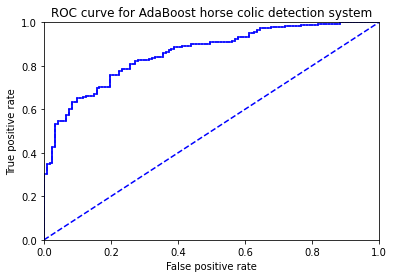

the Area Under the Curve is:  0.8582969635063604


In [90]:
plotROC(aggClassEst.T,labelArr)